## Modelo base


Neste teste será considerada a base de dados completa, sem considerar o pré-processamento dos dados indicado no capítulo "Pré Processamento".

### Bibliotecas e base de dados

In [1]:
# Importar bibliotecas
import pandas as pd
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skopt import BayesSearchCV
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

#Estilizar conteúdo
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

# Importar a base de dados

object_columns = ['Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'regiao',
                  'Setores Censitários', 'Status', 'DH_Descricao', 'DM_Descricao',
                  'DA_Descricao', 'DA_Polui/cont da água', 'DA_Polui/cont do ar',
                  'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico',
                  "DA_Incêndi parques/APA's/APP's", 'PEPL_Descricao', 'PEPR_Descricao',
                  'Categoria', 'Grupo', 'Subgrupo', 'Tipo', 'Subtipo']

dtype = {col: 'object' for col in object_columns}

df_eventos = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_desastres_rec_nrec.csv",
    sep=';',
    dtype = dtype,
    decimal=',',
)

estilo_tabelas(df_eventos.head(5))

C:\Users\Bruna\AppData\Local\Temp\ipykernel_7376\1379500647.py:53: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eventos = pd.read_csv(


,Protocolo_S2iD,Nome_Municipio,Sigla_UF,regiao,Data_Registro,Data_Evento,codigo_ibge,Setores Censitários,Status,DH_Descricao,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DH_total_danos_humanos,DM_Descricao,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,DM_total_danos_materiais,DA_Descricao,DA_Polui/cont da água,DA_Polui/cont do ar,DA_Polui/cont do solo,DA_Dimi/exauri hídrico,DA_Incêndi parques/APA's/APP's,PEPL_Descricao,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPL_total_publico,PEPR_Descricao,PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),PEPR_total_privado,PE_PLePR,Ano_Evento,Empenhado,DensidadePop,Area,Município - UF,PIB,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Categoria,Grupo,Subgrupo,Tipo,Subtipo,COBRADE,Pop
0,SP-A-3550001-12200-20100101,São Luiz do Paraitinga,SP,Sudeste,2010-01-01,2010-01-01,3550001,nan,Reconhecido,nan,0,0,0,93,4030,0,16,4139,nan,49,20,20643486.932,3.000,0,1121928.638,9.000,1,5235666.976,0,0,0.000,3,3,32411.272,25.000,0.000,65321178.458,92354672.275,nan,nan,nan,nan,nan,nan,nan,7978.159,673157.183,623293.688,2493.175,0.000,330993.880,3739.762,58609.552,0.000,0.000,1087024.191,2787289.589,nan,1642902.433,1149353.560,379785.310,0.000,24433.113,3196474.416,5983764.005,2010,nan,nan,nan,São Luiz do Paraitinga - SP,86448.000,nan,nan,nan,nan,nan,nan,Natural,Hidrológico,Enxurradas,nan,nan,12200,10397.000
1,SP-A-3518305-11321-20100101,Guararema,SP,Sudeste,2010-01-01,2010-01-01,3518305,nan,Reconhecido,nan,4,2,0,66,417,0,14430,14919,nan,161,91,18604069.987,0.000,0,0.000,2.000,0,24931.748,0,0,0.000,0,0,37397.621,9000.000,0.000,57771845.314,76438244.669,nan,nan,nan,nan,nan,nan,nan,0.000,179508.582,264276.524,12465.874,0.000,349044.465,74795.243,134631.437,0.000,0.000,77288.417,1092010.541,nan,441291.931,2049389.645,0.000,0.000,112192.889,2602874.464,3694885.005,2010,nan,nan,nan,Guararema - SP,1111405.000,nan,nan,nan,nan,nan,nan,Natural,Geológico,Movimento de massa,Deslizamentos,Deslizamentos de solo e ou rocha,11321,25844.000
2,BA-A-2905909-14110-20100101,Campo Alegre de Lourdes,BA,Nordeste,2010-01-01,2010-01-01,2905909,nan,Reconhecido,nan,0,0,0,0,0,0,0,0,nan,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,747.952,448771.455,0.000,0.000,0.000,0.000,0.000,249317.475,0.000,0.000,177015.407,875852.290,nan,254303.825,147097.310,0.000,0.000,0.000,401401.135,1277253.425,2010,nan,9.638,2914.587,Campo Alegre de Lourdes - BA,107459.000,nan,nan,nan,nan,nan,nan,Natural,Climatológico,Seca,Estiagem,nan,14110,28090.000
3,SP-A-3513603-12100-20100101,Cunha,SP,Sudeste,2010-01-01,2010-01-01,3513603,nan,Reconhecido,nan,6,0,0,38,492,0,12000,12536,nan,89,9,3340854.165,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,3.000,400.000,8052097.614,11392951.779,nan,nan,nan,nan,nan,nan,nan,0.000,1246.587,0.000,0.000,0.000,1994539.800,0.000,125656.007,0.000,0.000,0.000,2121442.395,nan,49863.495,1383711.986,0.000,0.000,925466.467,2359041.949,4480484.344,2010,nan,15.538,1407.250,Cunha - SP,112225.000,nan,nan,nan,nan,nan,nan,Natural,Hidrológico,Inundações,nan,nan,12100,21866.000
4,BA-P-2917334-12200-20100101,Iuiu,BA,Nordeste,2010-01-01,2010-01-01,2917334,nan,Reconhecido,nan,0,0,0,0,0,0,0,0,

### Ajustes da base de dados

In [2]:
# Remover colunas com mais de 50% de dados ausentes
colunas_para_remover = [
    'Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'Data_Registro', 'Data_Evento', 'codigo_ibge', 
    'Setores Censitários', 'DH_Descricao', 'DM_Descricao', 'DA_Descricao', 'DA_Polui/cont da água', 
    'DA_Polui/cont do ar', 'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico', 'PEPL_Descricao', 'DA_Incêndi parques/APA\'s/APP\'s', 
    'PEPR_Descricao', 'Ano_Evento', 'Empenhado', 'Município - UF', 'Subgrupo', 'Tipo', 'Subtipo', 'COBRADE'
]

df_eventos_limpa = df_eventos.drop(columns=colunas_para_remover)

# Remover linhas com NA
df_eventos_limpa = df_eventos_limpa.dropna()

# Encoding das variáveis categóricas mantidas
categorias = ['regiao', 'Categoria', 'Grupo']
df_eventos_limpa = pd.get_dummies(df_eventos_limpa, columns=categorias, drop_first=False, dtype=int)

# Shuffle das linhas porque os eventos são registrados por sequência temporal
df_eventos_limpa = df_eventos_limpa.sample(frac=1, random_state=1).reset_index(drop=True)

# Encoding da variável target
df_eventos_limpa['Status'] = df_eventos_limpa['Status'].map({'Reconhecido': 0, 'Não reconhecido': 1})

print("Antes, a base de dados possuia a seguinte dimensão:", df_eventos.shape)
print("Após a eliminação das colunas com mais de 50% de dados ausentes e das linhas com dados ausentes, a base de dados passou a ter a seguinte dimensão:", df_eventos_limpa.shape)
estilo_tabelas(df_eventos_limpa.head(5))

Antes, a base de dados possuia a seguinte dimensão: (26258, 84)
Após a eliminação das colunas com mais de 50% de dados ausentes e das linhas com dados ausentes, a base de dados passou a ter a seguinte dimensão: (5474, 73)


,Status,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DH_total_danos_humanos,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,DM_total_danos_materiais,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPL_total_publico,PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),PEPR_total_privado,PE_PLePR,DensidadePop,Area,PIB,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Pop,regiao_Centro-oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,Categoria_Natural,Categoria_Tecnológico,Grupo_Biológico,Grupo_Climatológico,Grupo_Desastres Relacionados a Incêndios Urbanos,Grupo_Desastres Relacionados a Produtos Perigosos,Grupo_Desastres relacionados a obras civis,Grupo_Desastres relacionados a transporte de passageiros e cargas não perigosas,Grupo_Geológico,Grupo_Hidrológico,Grupo_Meteorológico
0,0,0,0,0,35,45,0,1500,1580,9,5,1178172.274,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,1178172.274,0.000,0.000,50783.288,25391.644,0.000,0.000,0.000,43673.627,0.000,0.000,0.000,119848.559,8125326.025,2031331.506,0.000,0.000,0.000,10156657.532,10276506.091,17.397,912.222,119609.000,0.753,0.708,0.988,0.724,0.679,243.000,15870.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,60,450,0,5205,5715,497,0,4754583.015,0.000,0,0.000,2.000,0,252457.835,0,0,0.000,0,0,0.000,8.000,0.000,12289688.271,17296729.121,0.000,0.000,77728.344,275038.756,0.000,0.000,0.000,538119.305,0.000,0.000,0.000,890886.405,66009.301,300868.483,0.000,0.000,0.000,366877.784,1257764.189,79.983,155.058,407247.000,0.360,0.040,0.000,0.000,0.000,25.000,12402.000,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,45228,45228,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,183556.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,183556.082,0.000,0.000,0.000,0.000,0.000,0.000,183556.082,51.952,864.349,752944.000,0.126,0.231,0.084,0.105,0.055,238.000,44905.000,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,73592.737,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,73592.737,147185.473,735927.367,0.000,0.000,0.000,883112.841,956705.577,24.149,156.568,70207.000,0.476,0.381,0.905,0.476,0.333,21.000,3781.000,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1385,1385,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,211947.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211947.082,229609.339,213418.936,0.000,0.000,0.000,443028.275,654975.357,14.104,261.194,43757.000,0.208,0.125,0.583,0.167,0.083,24.000,3684.000,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [3]:
# Balanceamento da variável target

status_counts = df_eventos_limpa['Status'].value_counts()
print("\nBalanceamento da variável 'Status':")
display(status_counts)


Balanceamento da variável 'Status':


Status
0    4998
1     476
Name: count, dtype: int64

### Modelo sem balanceamento

#### Treino e teste

In [4]:
X = df_eventos_limpa.drop('Status', axis=1)

y = df_eventos_limpa['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#### Treinamento sem balanceamento

Inicialmente, o modelo foi treinado utilizando-se a busca de hiperparâmetros bayesiana com o objetivo de testar os hiperparâmetros. O teste foi feito a partir dos hiperparâmetros sugeridos por Thakur (2020). Com o objetivo de otimizar os resultados, foi utilizada a busca de hiperparâmetros bayesiana.

Interessante notar que a busca de hiperparâmetros pelo método tradicional (GridSearchCV) levou mais de um dia para ser processada. A busca de hiperparâmetros pelo método bayesiano (BayesSearchCV), por outro lado, foi processada em 2 minutos.

In [5]:
# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'xgb__eta': [0.01, 0.015, 0.025, 0.05, 0.1],  # Taxa de aprendizado
    'xgb__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],  # Redução mínima da perda
    'xgb__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],  # Profundidade da árvore
    'xgb__min_child_weight': [1, 3, 5, 7],  # Peso mínimo para divisão do nó
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subamostragem para treinamento
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subamostragem de colunas
    'xgb__lambda': [0.01, 0.1, 1.0],  # Regularização L2
    'xgb__alpha': [0, 0.1, 0.5, 1.0]  # Regularização L1
}

# Criar pipeline com RobustScaler e XGBoost Classifier
pipeline_xgb = Pipeline([
    ('scaler', RobustScaler()),  # Alterado para RobustScaler
    ('xgb', xgb.XGBClassifier(random_state=1, eval_metric='logloss'))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_xgb = BayesSearchCV(
    pipeline_xgb,
    search_spaces=param_grid_bayes,
    n_iter=30, 
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=1
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_xgb.fit(X_train, y_train)

# Melhor modelo encontrado
best_xgb_model = bayes_search_xgb.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_xgb.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_xgb = best_xgb_model.predict(X_test)

# Relatório de classificação
classification_report_xgb = metrics.classification_report(y_test, y_pred_xgb, digits=6, target_names=['Reconhecido', 'Não reconhecido'])
print('Classification report para XGBoost: \n')
print(classification_report_xgb)

Melhores hiperparâmetros: OrderedDict({'xgb__alpha': 0.5, 'xgb__colsample_bytree': 1.0, 'xgb__eta': 0.05, 'xgb__gamma': 0.3, 'xgb__lambda': 0.01, 'xgb__max_depth': 17, 'xgb__min_child_weight': 1, 'xgb__subsample': 0.6})
Classification report para XGBoost: 

                 precision    recall  f1-score   support

    Reconhecido   0.930516  0.991000  0.959806      1000
Não reconhecido   0.700000  0.221053  0.336000        95

       accuracy                       0.924201      1095
      macro avg   0.815258  0.606026  0.647903      1095
   weighted avg   0.910517  0.924201  0.905686      1095



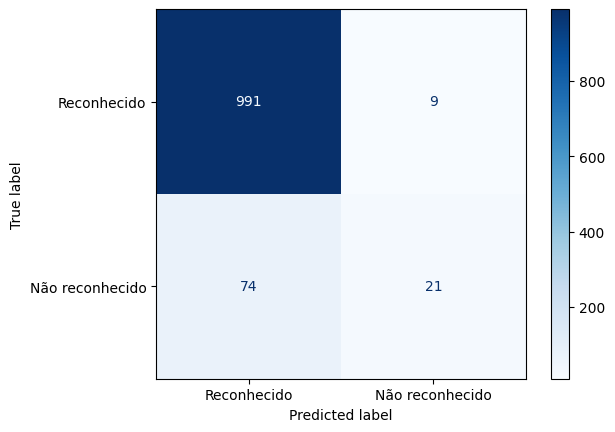

In [6]:
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])

### Modelo com balanceamento SMOTE

Inicialmente, o modelo foi treinado utilizando-se a busca de hiperparâmetros bayesiana com o objetivo de testar os hiperparâmetros. O teste foi feito a partir dos hiperparâmetros sugeridos por Thakur (2020).

#### Treino e teste

In [7]:
X_smote = df_eventos_limpa.drop('Status', axis=1)

y_smote = df_eventos_limpa['Status']

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=1, stratify=y)

#### Treinamento com balanceamento SMOTE

### Avaliação das Variáveis de Importância

#### Feature importance

#### Permutation importance